In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [10]:
import sys

sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d

import config
from audio import audio_to_melspectrogram, show_melspectrogram
from utils import load_labels, show_spectrograms

<IPython.core.display.Javascript object>

## Load data

In [17]:
# read data
X_train = np.load("../data/DOCC10_train/DOCC10_Xtrain.npy")
X_test = np.load("../data/DOCC10_test/DOCC10_Xtest.npy")
Y_train_df = pd.read_csv("../data/DOCC10_train/DOCC10_Ytrain.csv", index_col=0)

# Shift indexes
Y_train_df.index = Y_train_df.index - 20960

all_classes = list(set(Y_train_df.TARGET.values))

print("X train", X_train.shape, "Y_train", Y_train_df.shape, "X_test", X_test.shape)

X train (113120, 8192) Y_train (113120, 1) X_test (20960, 8192)


<IPython.core.display.Javascript object>

## Segment clicks 

In [13]:
def get_center(x_r):
    # Parameters
    cutoff = 10000
    win_size = 50
    gaussian_std = 5
    fs = 200000
    nyq = fs // 2
    order = 2
    normal_cutoff = cutoff / nyq

    # Butterworth highpass filter
    b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
    x_h = signal.filtfilt(b, a, x_r)

    # Wiener filter
    x_w = signal.wiener(x_h, mysize=win_size)

    # Gaussian filter
    x_g = gaussian_filter1d(np.abs(x_w), gaussian_std)

    # Argmax of the resulting signal
    center = x_g.argmax()

    return center

<IPython.core.display.Javascript object>

In [14]:
def show_centers(n_plots, classes):
    fig, axes = plt.subplots(
        n_plots, len(classes), figsize=(2 * len(classes), 2 * n_plots)
    )
    for j in range(len(classes)):
        X_sub = X_train[(Y_train_df == classes[j]).values.flatten()]
        axes[0, j].set_title(classes[j])
        for i in range(n_plots):
            idx = np.random.randint(len(X_sub))
            center = get_center(X_sub[idx])
            axes[i, j].plot(X_sub[idx])
            axes[i, j].axvline(x=center, color="red")
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
    plt.show()

<IPython.core.display.Javascript object>

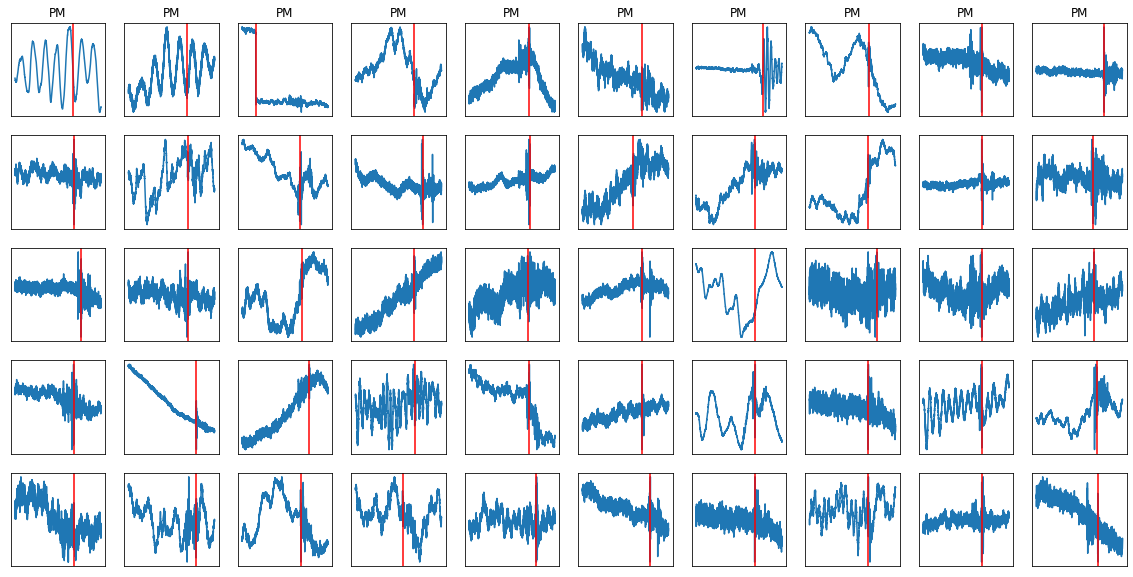

<IPython.core.display.Javascript object>

In [16]:
show_centers(5, ["PM"] * 10)

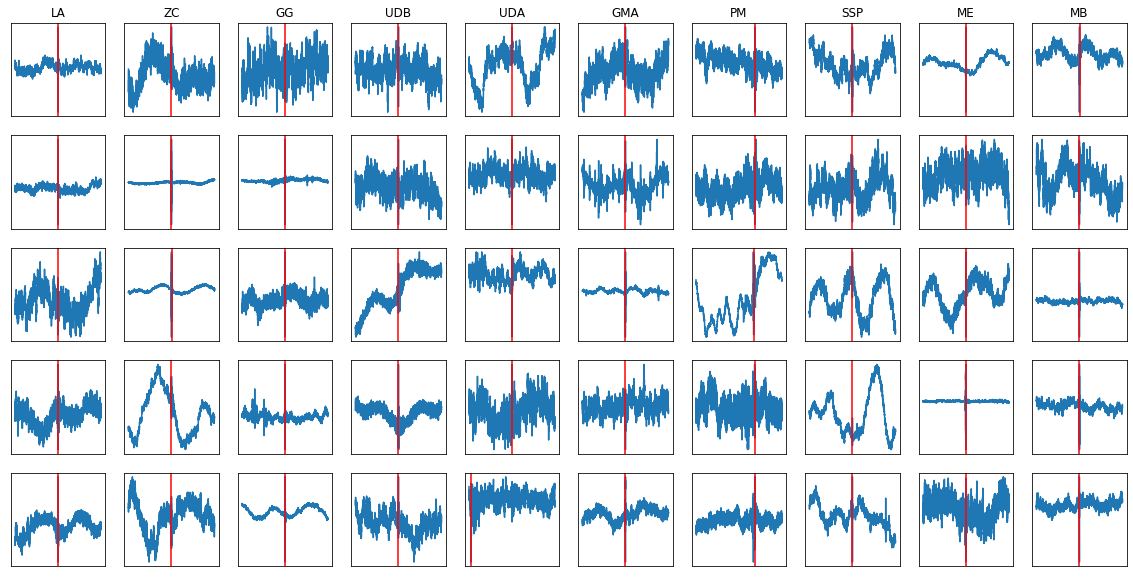

<IPython.core.display.Javascript object>

In [18]:
show_centers(5, all_classes)

In [29]:
def segment_clicks(x, cls=None, width=2 ** 8):
    T = len(x)
    assert width < T
    if cls == "PM":
        center = get_center(x)
    else:
        center = 2 ** 12
    if center - width // 2 < 0:
        min_t = 0
        max_t = width
    elif center + width // 2 >= T:
        min_t = -width
        max_t = T
    else:
        min_t = center - width // 2
        max_t = center + width // 2
    x_sub = x[min_t:max_t]
    assert len(x_sub) == width
    return x_sub

<IPython.core.display.Javascript object>

In [43]:
def get_power_spectrum(x, n_fft=64):
    n_fft = 64
    cutoff = 10000
    f_sampling = 200000
    window = signal.get_window(("gaussian", 30), n_fft)

    f, pspec = signal.welch(x, f_sampling, window, n_fft, scaling="spectrum")

    # Keep only freq > 10kHz
    pspec = pspec[f > cutoff]
    f = f[f > cutoff]
    return f, pspec

<IPython.core.display.Javascript object>

In [80]:
def show_temporal(x):
    plt.figure(figsize=(10, 5))
    plt.title("Signal")
    plt.plot(x)
    plt.yticks([])
    plt.show()


def show_power_spectrum(f, ps):
    plt.figure(figsize=(10, 5))
    plt.title("Power spectrum")
    N = len(f)
    ind = np.arange(N)
    delta = f[1] - f[0]
    xlabels = (f - delta / 2).astype(int)
    plt.bar(x=ind, height=ps)
    plt.xticks(ind, xlabels, rotation=45)
    plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>

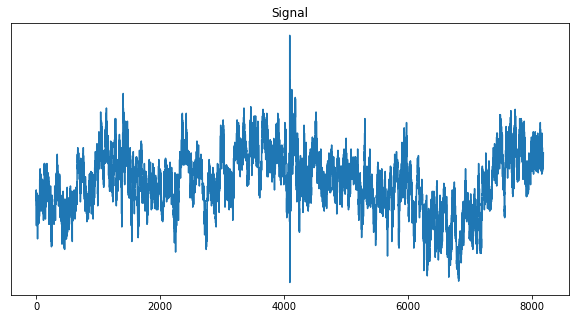

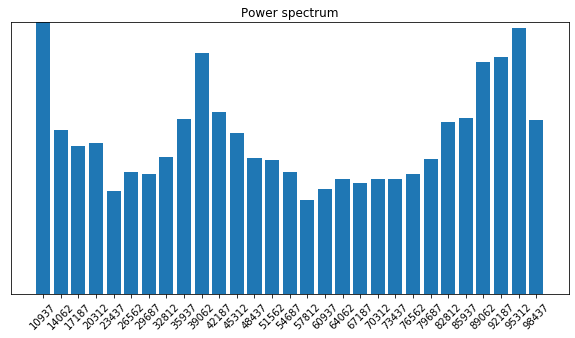

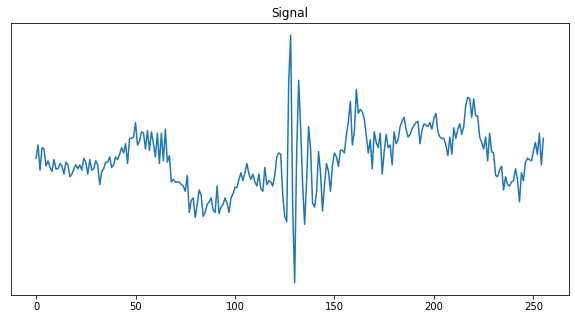

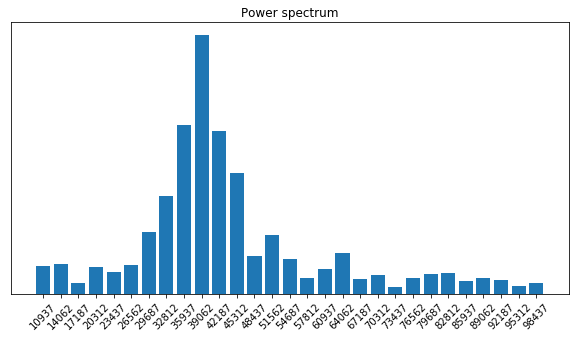

<IPython.core.display.Javascript object>

In [81]:
# Test
x = X_train[0]
f, ps = get_power_spectrum(x, n_fft=64)
x_c = segment_clicks(x, cls=None, width=2 ** 8)
f_c, ps_c = get_power_spectrum(x_c, n_fft=64)

show_temporal(x)
show_power_spectrum(f, ps)
show_temporal(x_c)
show_power_spectrum(f_c, ps_c)